# Develop and Interpret a Hierarchical Clustering

## Step 1: Load Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("https://ucarecdn.com/8d8cd2ee-47d4-474f-b3a7-66eb9a20b43e/retail_data_clean.csv")
df.head()

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Quantity,UnitPrice,Revenue
0,13047,536367,2010-12-01 08:34:00,84879,32,1.69,54.08
1,13047,536367,2010-12-01 08:34:00,22745,6,2.10,12.60
2,13047,536367,2010-12-01 08:34:00,22748,6,2.10,12.60
3,13047,536367,2010-12-01 08:34:00,22749,8,3.75,30.00
4,13047,536367,2010-12-01 08:34:00,22310,6,1.65,9.90


## Step 2: Order Volumes

In [2]:
order_volume_df = df.groupby(['CustomerID']).agg({
    'Revenue': "mean",
    'Quantity': "sum"
})
order_volume_df.columns = ['AvgRevenue', 'TotalQuantity']
order_volume_df

,AvgRevenue,TotalQuantity
CustomerID,,
12347,23.681319,2458
12349,20.243750,630
12363,24.000000,408
12370,20.636687,2350
12381,17.985488,797
...,...,...
18265,17.424130,311
18270,25.740909,101
18278,19.322222,66


<AxesSubplot:xlabel='AvgRevenue', ylabel='TotalQuantity'>

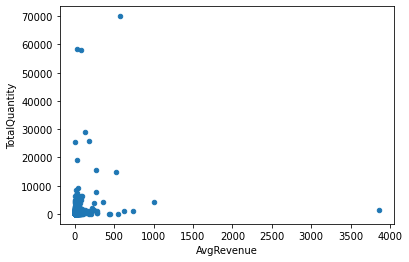

In [3]:
(order_volume_df
.plot
.scatter(x = 'AvgRevenue', y='TotalQuantity'))

## Step 3: Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = order_volume_df
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
scaled_df.describe()

,AvgRevenue,TotalQuantity
count,1.000000e+03,1.000000e+03
mean,-2.664535e-17,1.776357e-17
std,1.000500e+00,1.000500e+00
min,-2.295691e-01,-2.860363e-01
25%,-1.568983e-01,-2.465267e-01
50%,-1.151867e-01,-1.943994e-01
75%,-6.877679e-02,-2.954225e-02
max,2.789808e+01,1.755473e+01


## Step 4: Hierarchical Clustering—Dendogram

Text(0.5, 0, 'Number of points in node (or index of point if no parentheses).')

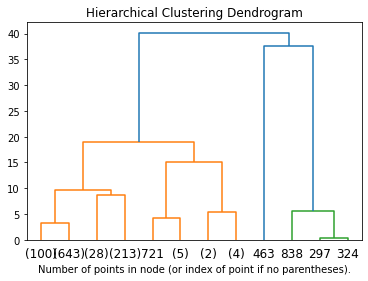

In [6]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
  # Create linkage matrix and then plot the dendrogram
  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for (i, merge) in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count
  linkage_matrix = np.column_stack([model.children_,
      model.distances_, counts]).astype(float)
  # Plot the corresponding dendrogram
  dendrogram(linkage_matrix, **kwargs)

X = scaled_df

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

fitted = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(fitted, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parentheses).")

## Step 5: Hierarchical Clustering—Fitting

In [7]:
fitted = AgglomerativeClustering(n_clusters=4 ).fit(scaled_df)

In [8]:
fitted.labels_[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
np.unique(fitted.labels_, return_counts = True)


(array([0, 1, 2, 3]), array([ 12, 984,   1,   3]))

## Step 6: Add Cluster Labels

In [10]:
order_volume_df['Cluster'] = fitted.labels_.astype(str)

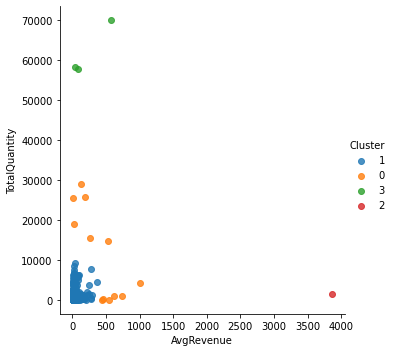

In [12]:
import seaborn as sns
sns.lmplot(x = 'AvgRevenue', y='TotalQuantity', data=order_volume_df, hue='Cluster', fit_reg=False)

## Step 7: Rename Clusters

In [13]:
largest_cluster = (order_volume_df                  
.groupby("Cluster")
.count()
.sort_values("AvgRevenue", ascending = False)
.reset_index()
.loc[0,'Cluster'])
largest_cluster

'1'

In [14]:
def rename_clusters(x):
  if x == largest_cluster:
    return("Consumer")
  else:
    return("Wholesale")

order_volume_df['segment'] = order_volume_df.apply(lambda x: rename_clusters(x['Cluster']), axis = 1)
order_volume_df.head()

,AvgRevenue,TotalQuantity,Cluster,segment
CustomerID,,,,
12347,23.681319,2458,1,Consumer
12349,20.243750,630,1,Consumer
12363,24.000000,408,1,Consumer
12370,20.636687,2350,1,Consumer
12381,17.985488,797,1,Consumer


In [15]:
order_volume_df[order_volume_df['segment'] == "Wholesale"]

,AvgRevenue,TotalQuantity,Cluster,segment
CustomerID,,,,
12748,7.056183,25511,0,Wholesale
13081,27.673223,19068,0,Wholesale
14156,84.159791,57872,3,Wholesale
14298,31.476665,58343,3,Wholesale
15061,135.320447,28920,0,Wholesale
15195,3861.000000,1404,2,Wholesale
15524,440.000000,4,0,Wholesale
16013,267.126619,15536,0,Wholesale
16716,450.600000,120,0,Wholesale


## Step 8: Export Customer IDs with Segments

In [16]:
segments_df = order_volume_df.reset_index()[['CustomerID', 'segment']].drop_duplicates()
segments_df

,CustomerID,segment
0,12347,Consumer
1,12349,Consumer
2,12363,Consumer
3,12370,Consumer
4,12381,Consumer
...,...,...
995,18265,Consumer
996,18270,Consumer
997,18278,Consumer
998,18280,Consumer


In [17]:
segments_df.to_csv('customerid_segments.csv', index = False)